In [72]:
import shlex
import subprocess
import re
import os
import concurrent.futures
import shutil

import seaborn as sns
import pandas as pd

In [73]:
class TestResult:
    psnr = 0
    def __init__(self, file, original_size, compressed, yuv, m, operation, time_taken):
        self.file = file
        self.original_size = original_size
        self.compressed = compressed
        self.yuv = yuv
        self.m = m
        self.operation = operation
        self.time_taken = time_taken

In [74]:
test_files_dir = "tests/resource/"
test_files = [
    "ducks_take_off_444_720p50.y4m",
    "in_to_tree_444_720p50.y4m",
    "old_town_cross_444_720p50.y4m",
    "park_joy_444_720p50.y4m",
]
#test_files = [
#    "akiyo_qcif.y4m",
#]
sizes = [os.path.getsize(test_files_dir + file) for file in test_files]

In [75]:
time_pattern = re.compile(r"(\d+\.\d+) seconds")
m_test_range = [2**x for x in range(1, 4)]
yuv_quantization = [(128, 64, 64), (64, 32, 32), (32, 16, 16)]
test_folder = "temp/"

results = []

In [76]:
def lossless_encode(file, m, original_size):
    encode = f"{file}{m}"
    command = f"bin/CSLPEncoder -c lossless_hybrid --mode encode -i {file} -o {encode} -m {m}"
    p1 = subprocess.Popen(
        args=shlex.split(command),
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE,
    )
    p1.wait()
    if p1.returncode != 0:
        print("Error: {}".format(p1.stdout.read()))
        exit(1)
    result = p1.stdout.read()
    time_taken = time_pattern.search(result.decode("utf-8")).group(1)
    compressed_size = os.path.getsize("encode")
    print("Time taken: {} seconds\n".format(time_taken))
    return TestResult(file, original_size, compressed_size, None, m, "encode", time_taken)

def lossy_encode(file, m, yuv, original_size):
    encode = f"{file}{m}_{yuv[0]}_{yuv[1]}_{yuv[2]}"
    command = f"bin/CSLPEncoder --mode encode -i {file} -o {encode} -m {m} -y {yuv[0]} -u {yuv[1]} -v {yuv[2]}"
    p1 = subprocess.Popen(
        args=shlex.split(command),
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE,
    )
    p1.wait()
    if p1.returncode != 0:
        print("Error: {}".format(p1.stdout.read()))
        exit(1)
    result = p1.stdout.read()
    time_taken = time_pattern.search(result.decode("utf-8")).group(1)
    compressed_size = os.path.getsize("encode")
    print("Time taken: {} seconds\n".format(time_taken))
    return TestResult(file, original_size, compressed_size, yuv, m, "encode", time_taken)

def decode(yuv, file, m, original_size):
    if yuv is None:
        encoder = "lossless_hybrid"
        encode = f"{file}{m}"
        decode = f"{encode}_decode"
    else:
        encoder = "hybrid"
        encode = f"{file}{m}_{yuv[0]}_{yuv[1]}_{yuv[2]}"
        decode = f"{encode}_decode"
    command = f"bin/CSLPEncoder -c {encoder} --mode decode -i {encode} -o {decode} -m {m}"
    p2 = subprocess.Popen(
        args=shlex.split(command),
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE,
    )
    p2.wait()
    if p2.returncode != 0:
        print("Error: {}".format(p2.stdout.read()))
        exit(1)
    result = p2.stdout.read()
    time_taken = time_pattern.search(result.decode("utf-8")).group(1)
    print("Time taken: {} seconds\n".format(time_taken))
    command = f"bin/CSLPEncoder --compare -i {file} -o {decode}"
    result_format = "Average PSNR: (\d+\.\d+|\w+)"
    p3 = subprocess.Popen(
        args=shlex.split(command),
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE,
    )
    p3.wait()
    if p3.returncode != 0:
        print("Error: {}".format(p3.stdout.read()))
        exit(1)
    result = p3.stdout.read()
    psnr = result_format.search(result.decode("utf-8")).group(1)
    print("PSNR: {}\n".format(psnr))
    result = TestResult(file, original_size, None, yuv, m, "decode", time_taken)
    result.psnr = psnr
    os.remove(encode)
    os.remove(decode)
    return TestResult(file, original_size, None, yuv, m, "decode", time_taken)

In [77]:
def encode_decode_lossless(file, m, original_size):
    return [lossless_encode(file, m, original_size), decode(None, file, m, original_size)]

def encode_decode_lossy(file, m, yuv, original_size):
    return [lossy_encode(file, m, yuv, original_size), decode(yuv, file, m, original_size)]

In [82]:
max_workers = os.cpu_count()

if os.path.exists(test_folder):
    shutil.rmtree(test_folder)
os.mkdir(test_folder)

with concurrent.futures.ProcessPoolExecutor(max_workers=max_workers) as executor:
    futures = []
    for i, file in enumerate(test_files):
        print(f"Generating results for {file}")
        file = test_folder + file
        print(file)
        original_size = sizes[i]
        for m in m_test_range:
            futures.append(executor.submit(encode_decode_lossless, file, m, original_size))
            for yuv in yuv_quantization:
                futures.append(executor.submit(encode_decode_lossy, file, m, yuv, original_size))
    for future in concurrent.futures.as_completed(futures):
        results += future.result()

Generating results for ducks_take_off_444_720p50.y4m
temp/ducks_take_off_444_720p50.y4m


Generating results for in_to_tree_444_720p50.y4m
temp/in_to_tree_444_720p50.y4m
Generating results for old_town_cross_444_720p50.y4m
temp/old_town_cross_444_720p50.y4m
Generating results for park_joy_444_720p50.y4m
temp/park_joy_444_720p50.y4m
Error: b'\n[I] Starting encoding with lossless_hybrid codec\n'
Error: b'\n[I] Quantizing steps: Y=128, U=64, V=64\n[I] Starting encoding with hybrid codec\n'
Error: b'\n[I] Quantizing steps: Y=64, U=32, V=32\n[I] Starting encoding with hybrid codec\n'
Error: b'\n[I] Starting encoding with lossless_hybrid codec\n'
Error: b'\n[I] Quantizing steps: Y=32, U=16, V=16\n[I] Starting encoding with hybrid codec\n'
Error: b'\n[I] Quantizing steps: Y=128, U=64, V=64\n[I] Starting encoding with hybrid codec\n'
Error: b'\n[I] Quantizing steps: Y=32, U=16, V=16\n[I] Starting encoding with hybrid codec\n'
Error: b'\n[I] Quantizing steps: Y=64, U=32, V=32\n[I] Starting encoding with hybrid codec\n'
Error: b'\n[I] Quantizing steps: Y=128, U=64, V=64\n[I] Starting

AttributeError: 'NoneType' object has no attribute 'group'

In [83]:
shutil.rmtree(test_folder)

In [ ]:
# This takes 2 hours to run btw
""" for i, file in enumerate(test_files):
    print("Generating graph for file: {}\n\n".format(file))
    ########################################
    encoder = "lossless_hybrid"
    print("Encoder: {}".format(encoder))
    for m in m_test_range:
        print("M: {}".format(m))
        # Encode
        print("Operation: encode")
        command = f"bin/CSLPEncoder -c {encoder} --mode encode -i {test_files_dir + file} -o encode -m {m}"
        p1 = subprocess.Popen(
            args=shlex.split(command),
            stdout=subprocess.PIPE,
            stderr=subprocess.PIPE,
        )
        p1.wait()
        if p1.returncode != 0:
            print("Error: {}".format(p1.stdout.read()))
            exit(1)
        result = p1.stdout.read()
        time_taken = time_pattern.search(result.decode("utf-8")).group(1)
        compressed_size = os.path.getsize("encode")
        print("Time taken: {} seconds\n".format(time_taken))
        results.append(TestResult(file, sizes[i], compressed_size, None, m, "encode", time_taken))
        # Decode
        print("Operation: decode")
        command = f"bin/CSLPEncoder -c {encoder} --mode decode -i encode -o decode"
        p2 = subprocess.Popen(
            args=shlex.split(command),
            stdout=subprocess.PIPE,
            stderr=subprocess.PIPE,
        )
        p2.wait()
        if p2.returncode != 0:
            print("Error: {}".format(p2.stdout.read()))
            exit(1)
        result = p2.stdout.read()
        time_taken = time_pattern.search(result.decode("utf-8")).group(1)
        print("Time taken: {} seconds\n".format(time_taken))
        results.append(TestResult(file, None, None, None, m, "decode", time_taken))
    ########################################
    encoder = "hybrid"
    print("Encoder: {}".format(encoder))
    for yuv in yuv_quantization:
        print("YUV: {}".format(yuv))
        for m in m_test_range:
            print("M: {}".format(m))
            # Encode
            print("Operation: encode")
            command = f"bin/CSLPEncoder -c {encoder} --mode encode -i {test_files_dir + file} -o encode -m {m} -y {yuv[0]} -u {yuv[1]} -v {yuv[2]}"
            p1 = subprocess.Popen(
                args=shlex.split(command),
                stdout=subprocess.PIPE,
                stderr=subprocess.PIPE,
            )
            p1.wait()
            if p1.returncode != 0:
                print("Error: {}".format(p1.stdout.read()))
                exit(1)
            result = p1.stdout.read()
            time_taken = time_pattern.search(result.decode("utf-8")).group(1)
            compressed_size = os.path.getsize("encode")
            print("Time taken: {} seconds\n".format(time_taken))
            results.append(TestResult(file, sizes[i], compressed_size, yuv, m, "encode", time_taken))
            # Decode
            print("Operation: decode")
            command = f"bin/CSLPEncoder -c {encoder} --mode decode -i encode -o decode"
            p2 = subprocess.Popen(
                args=shlex.split(command),
                stdout=subprocess.PIPE,
                stderr=subprocess.PIPE,
            )
            p2.wait()
            if p2.returncode != 0:
                print("Error: {}".format(p2.stdout.read()))
                exit(1)
            result = p2.stdout.read()
            time_taken = time_pattern.search(result.decode("utf-8")).group(1)
            print("Time taken: {} seconds\n".format(time_taken))
            results.append(TestResult(file, None, None, yuv, m, "decode", time_taken))
######################################## """

Generating graph for file: akiyo_qcif.y4m


Encoder: lossless_hybrid
M: 2
Operation: encode
Time taken: 0.478313 seconds

Operation: decode
Time taken: 0.704952 seconds

M: 4
Operation: encode
Time taken: 0.504598 seconds

Operation: decode
Time taken: 0.764067 seconds

M: 8
Operation: encode
Time taken: 0.488258 seconds

Operation: decode
Time taken: 0.775099 seconds

Encoder: hybrid
YUV: (128, 64, 64)
M: 2
Operation: encode
Time taken: 1.60299 seconds

Operation: decode
Time taken: 0.594056 seconds

M: 4
Operation: encode
Time taken: 1.65422 seconds

Operation: decode
Time taken: 0.607086 seconds

M: 8
Operation: encode
Time taken: 1.68383 seconds

Operation: decode
Time taken: 0.675159 seconds

YUV: (64, 32, 32)
M: 2
Operation: encode
Time taken: 1.59453 seconds

Operation: decode
Time taken: 0.541501 seconds

M: 4
Operation: encode
Time taken: 1.67061 seconds

Operation: decode
Time taken: 0.582057 seconds

M: 8
Operation: encode
Time taken: 1.65423 seconds

Operation: decode
Time 

In [84]:
folder = "graphs/"
df = pd.DataFrame([x.__dict__ for x in results])
if not os.path.exists(folder):
    os.makedirs(folder)
save_path = folder + "test_results"
extension = ".csv"
if os.path.exists(folder + "test_results.csv"):
    i = 1
    while os.path.exists(save_path + str(i) + extension):
        i += 1
    save_path += str(i)
    
df.to_csv(save_path + extension)

In [85]:
file = "test_results.csv"
df = pd.read_csv(folder + file)
df = df[df.file != "akiyo_qcif.y4m"]

results = []
for _, row in df.iterrows():
    results.append(TestResult(row["file"], row["original_size"], row["compressed"], row["yuv"], row["m"], row["operation"], row["time_taken"]))

In [86]:
sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(12, 8)})

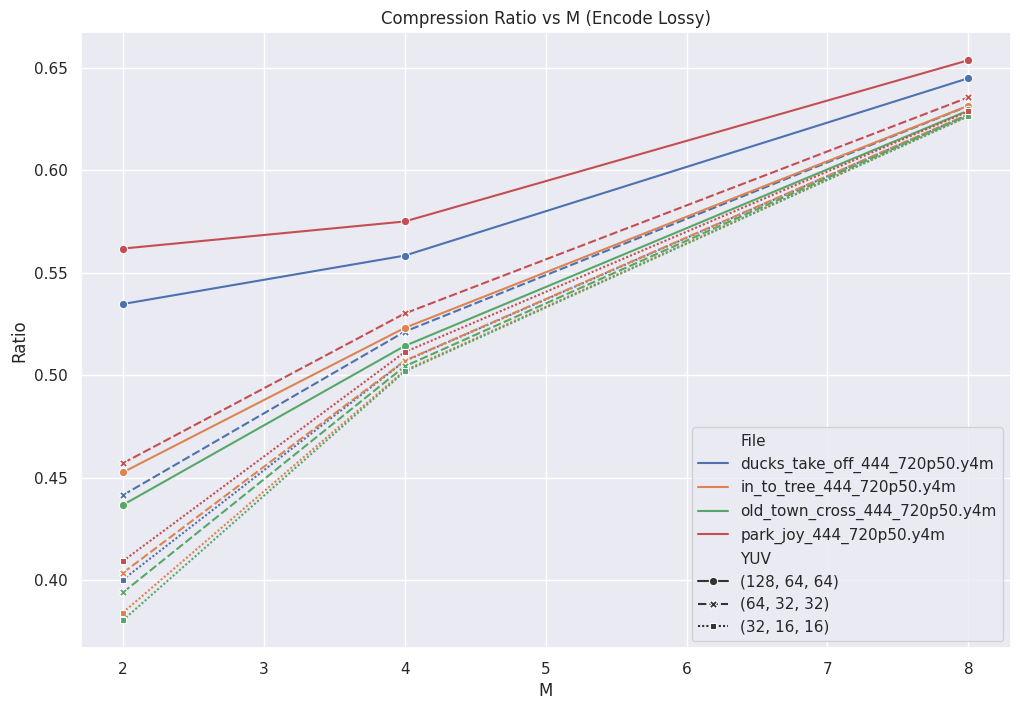

In [87]:
filtered = [result for result in results if result.operation == "encode" and pd.notna(result.yuv)]

original_size = [result.original_size for result in filtered]
compressed_size = [result.compressed for result in filtered]
ratio = [result.compressed / result.original_size for result in filtered]

df = pd.DataFrame(
    {
        "Ratio": ratio,
        "M": [result.m for result in filtered],
        "File": [result.file for result in filtered],
        "YUV": [result.yuv for result in filtered],
    }
)

g = sns.lineplot(data=df, x="M", y="Ratio", hue="File", style="YUV", markers=True).set_title("Compression Ratio vs M (Encode Lossy)")
g.figure.savefig(folder + "compression_lossy.png")

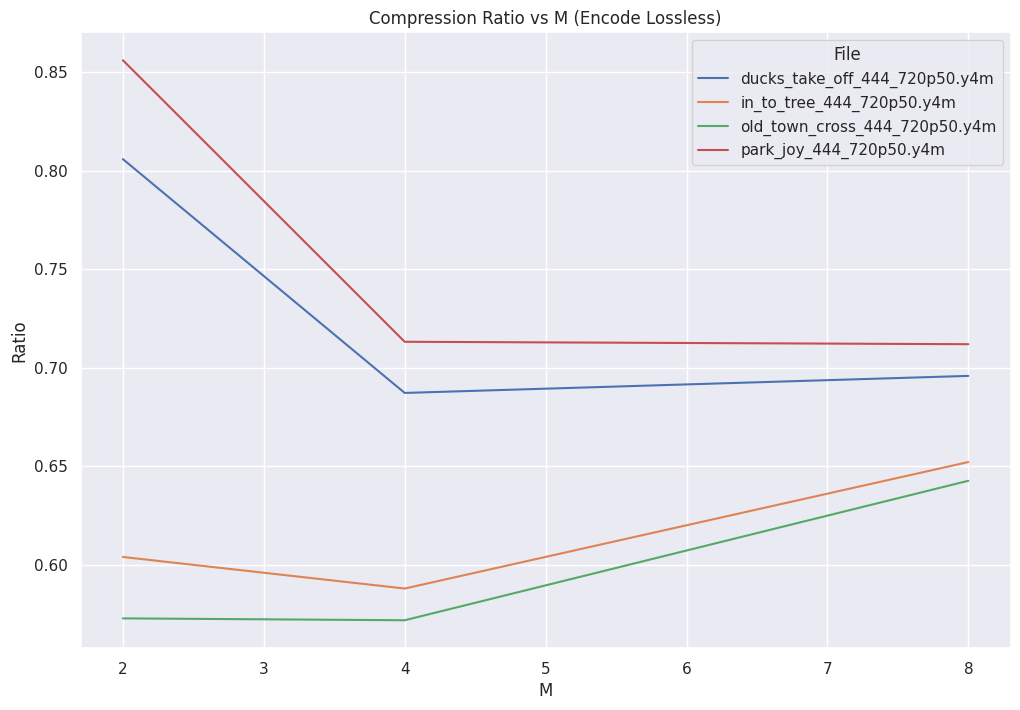

In [88]:
filtered = [result for result in results if result.operation == "encode" and pd.isna(result.yuv)]

original_size = [result.original_size for result in filtered]
compressed_size = [result.compressed for result in filtered]
ratio = [result.compressed / result.original_size for result in filtered]

df = pd.DataFrame(
    {
        "Ratio": ratio,
        "M": [result.m for result in filtered],
        "File": [result.file for result in filtered],
    }
)

g = sns.lineplot(data=df, x="M", y="Ratio", hue="File", markers=True).set_title("Compression Ratio vs M (Encode Lossless)")
g.figure.savefig(folder + "compression_lossless.png")

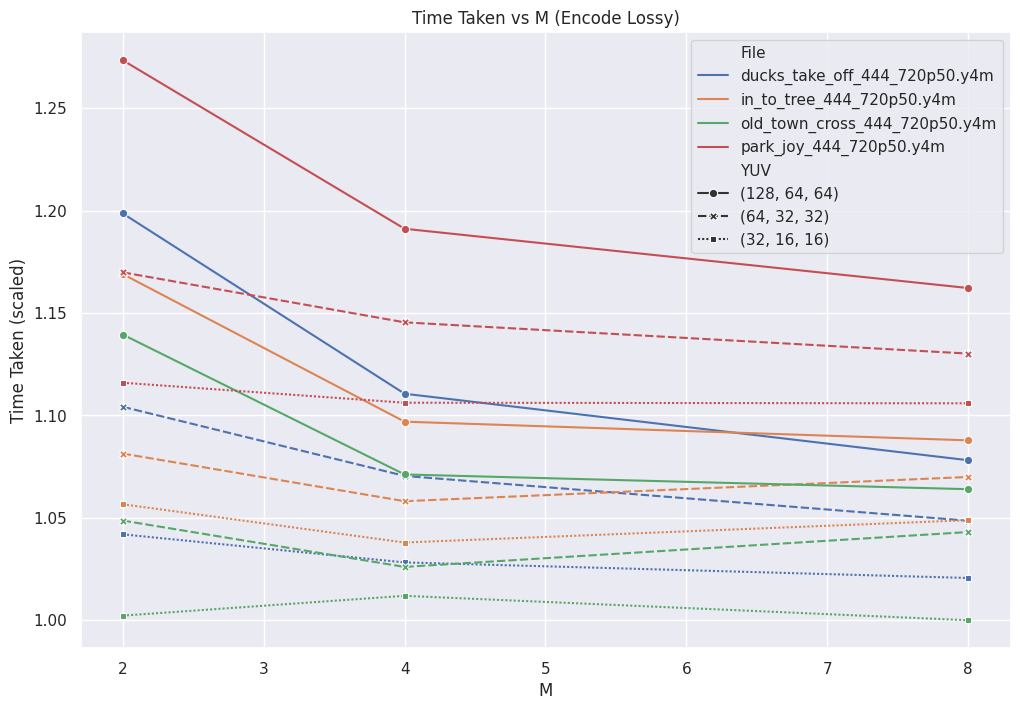

In [89]:
filtered = [result for result in results if result.operation == "encode" and pd.notna(result.yuv)]

## Time taken adjusted to the fastest time taken for each file
time_taken = [result.time_taken for result in filtered]
time_taken = [float(x) for x in time_taken]
fastest_time_taken = min(time_taken)
time_taken = [x / fastest_time_taken for x in time_taken]

df = pd.DataFrame(
    {
        "Time Taken (scaled)": time_taken,
        "M": [result.m for result in filtered],
        "File": [result.file for result in filtered],
        "YUV": [result.yuv for result in filtered],
    }
)

g = sns.lineplot(data=df, x="M", y="Time Taken (scaled)", hue="File", style="YUV", markers=True).set_title("Time Taken vs M (Encode Lossy)")
g.figure.savefig(folder + "time_lossy.png")

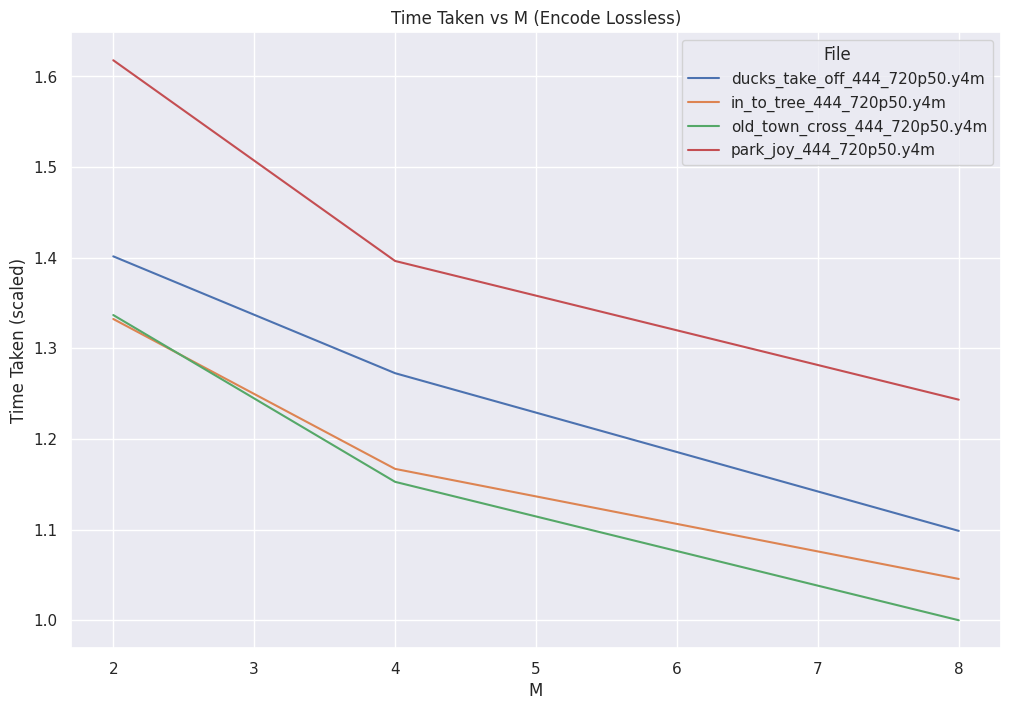

In [90]:
filtered = [result for result in results if result.operation == "encode" and pd.isna(result.yuv)]

## Time taken adjusted to the fastest time taken for each file
time_taken = [result.time_taken for result in filtered]
time_taken = [float(x) for x in time_taken]
fastest_time_taken = min(time_taken)
time_taken = [x / fastest_time_taken for x in time_taken]

df = pd.DataFrame(
    {
        "Time Taken (scaled)": time_taken,
        "M": [result.m for result in filtered],
        "File": [result.file for result in filtered],
    }
)

g = sns.lineplot(data=df, x="M", y="Time Taken (scaled)", hue="File", markers=True).set_title("Time Taken vs M (Encode Lossless)")
g.figure.savefig(folder + "time_lossless.png")

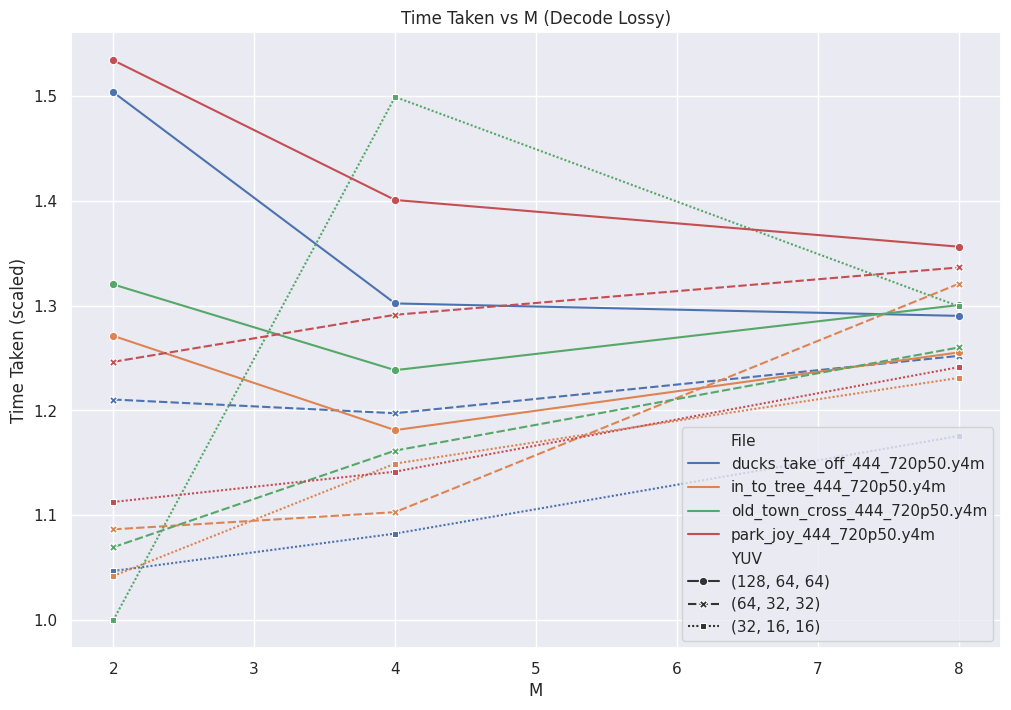

In [91]:
filtered = [result for result in results if result.operation == "decode" and result.yuv is not None]

## Time taken adjusted to the fastest time taken for each file
time_taken = [result.time_taken for result in filtered]
time_taken = [float(x) for x in time_taken]
fastest_time_taken = min(time_taken)
time_taken = [x / fastest_time_taken for x in time_taken]

df = pd.DataFrame(
    {
        "Time Taken (scaled)": time_taken,
        "M": [result.m for result in filtered],
        "File": [result.file for result in filtered],
        "YUV": [result.yuv for result in filtered],
    }
)

g = sns.lineplot(data=df, x="M", y="Time Taken (scaled)", hue="File", style="YUV", markers=True).set_title("Time Taken vs M (Decode Lossy)")
g.figure.savefig(folder + "time_lossy_decode.png")

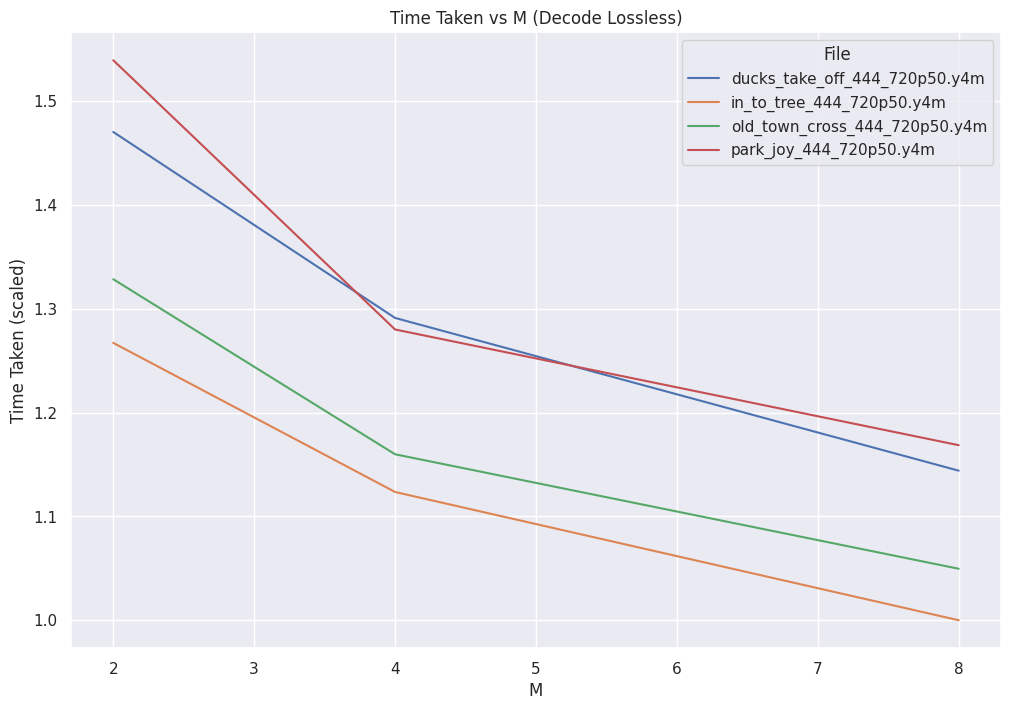

In [92]:
filtered = [result for result in results if result.operation == "decode" and pd.isna(result.yuv)]

## Time taken adjusted to the fastest time taken for each file
time_taken = [result.time_taken for result in filtered]
time_taken = [float(x) for x in time_taken]
fastest_time_taken = min(time_taken)
time_taken = [x / fastest_time_taken for x in time_taken]

df = pd.DataFrame(
    {
        "Time Taken (scaled)": time_taken,
        "M": [result.m for result in filtered],
        "File": [result.file for result in filtered],
    }
)

g = sns.lineplot(data=df, x="M", y="Time Taken (scaled)", hue="File", markers=True).set_title("Time Taken vs M (Decode Lossless)")
g.figure.savefig(folder + "time_lossless_decode.png")

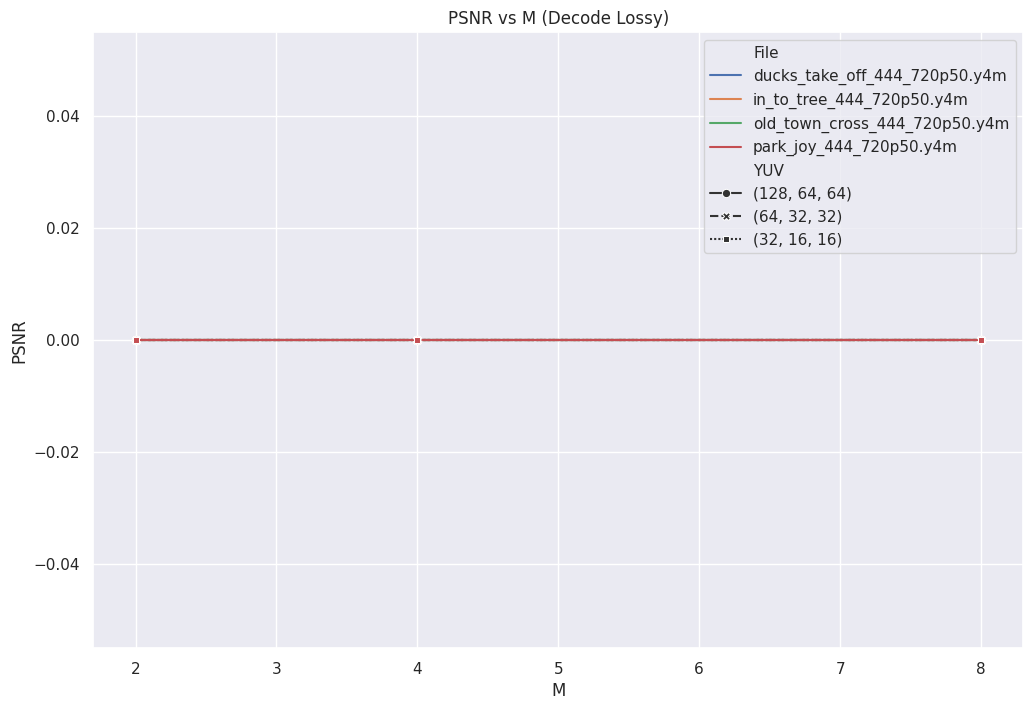

In [94]:
filtered = [result for result in results if result.operation == "decode" and pd.notna(result.yuv)]

psnr = [float(result.psnr) for result in filtered]

df = pd.DataFrame(
    {
        "PSNR": psnr,
        "M": [result.m for result in filtered],
        "File": [result.file for result in filtered],
        "YUV": [result.yuv for result in filtered],
    }
)

g = sns.lineplot(data=df, x="M", y="PSNR", hue="File", style="YUV", markers=True).set_title("PSNR vs M (Decode Lossy)")
g.figure.savefig(folder + "psnr.png")